# Delivaery Duration Prediction For DoorDash

# Table of Contents

* [Business Problem Statement](#business-problem-statement)
* [Data Description](#data-description)
* [Exploratory Data Analysis](#exploratory-data-analysis)
* [Remove Redundant and Collinear Features](#remove-redundant-and-collinear-features)
* [Multicollinearity Check](#multicollinearity-check)
* [Feature Selection](#feature-selection)
* [Apply Scaler](#apply-scaler)
* [Inverse Transform for Metric Comparison](#inverse-transform-for-metric-comparison)
* [Classical Machine Learning](#classical-machine-learning)
* [Deep Learning](#deep-learning)

<a name="business-problem-statement"></a>

# Business Problem Statement:

For a food delivery platform, ensuring accurate delivery time estimates is crucial for enhancing customer satisfaction. When a customer places an order, providing an accurate estimation of the delivery time significantly impacts their overall experience. In this task, the objective is to develop a predictive model that accurately forecasts the total delivery duration in seconds. This duration encompasses the time from the moment the customer submits the order (created_at) to the anticipated delivery time (actual_delivery_time). By creating a reliable model to predict delivery times, the platform aims to optimize service efficiency, minimize delivery delays, and ultimately enhance the overall customer experience.


![Image](https://techcult.com/wp-content/uploads/2022/06/How-to-get-biggest-DoorDash-order.png)

<a name="data-description"></a>

# Data Description:

The provided file historical_data.csv presents a portion of the deliveries received by a food delivery platform in early 2015, focusing on select cities. Each row within this dataset represents a distinct delivery instance. To protect proprietary business information, noise has been introduced into the dataset. Each column in the file represents a feature, with all monetary values denoted in cents and time durations expressed in seconds. The primary objective of this dataset is to predict the total duration, measured in seconds, between the time the order was placed (created_at) and the time it was actually delivered to the customer (actual_delivery_time)

Columns in the historical_data.csv dataset include:

**Time features:**

* market_id: Represents the city or region where DoorDash operates, given as an ID.

* created_at: Timestamp in UTC indicating when the order was submitted by the consumer to DoorDash.

* actual_delivery_time: Timestamp in UTC indicating when the order was delivered to the consumer.

**Store features:**

* store_id: An ID representing the restaurant where the order was submitted.

* store_primary_category: Cuisine category of the restaurant, such as Italian or Asian.

* order_protocol: An ID denoting the protocol through which the store receives orders from DoorDash.

**Order features:**

* total_items: Total number of items in the order.

* subtotal: Total value of the order submitted (in cents).
num_distinct_items: Number of distinct items included in the order.

* min_item_price: Price of the item with the lowest cost in the order (in cents).

* max_item_price: Price of the item with the highest cost in the order (in cents).

**Market features:**

* total_onshift_dashers: Number of available dashers within 10 miles of the store at the time of order creation.

* total_busy_dashers: Subset of the total on-shift dashers who are currently working on an order.

* total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

**Predictions from other models:**

* estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds).

* estimated_store_to_consumer_driving_duration: Estimated travel time between the store and the consumer (in seconds).

These features provide valuable insights into the conditions and parameters surrounding the delivery process, which are crucial for predicting delivery durations accurately.







<a name="exploratory-data-analysis"></a>

# Exploratory Data Analysis:

Importing required libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

Importing historical delivery data stored in a CSV file. This dataset likely contains a comprehensive record of past deliveries, including various attributes such as timestamps of order creation and delivery, details about the stores involved, order-specific features like the total number of items and subtotal, as well as market conditions at the time of order submission. By importing this historical data into a DataFrame, it becomes possible to perform extensive analysis and modeling tasks aimed at predicting delivery durations. Understanding patterns and trends from past deliveries can inform optimization strategies and improve efficiency in future delivery operations. This dataset serves as a valuable resource for data-driven decision-making processes within the delivery management domain.

In [80]:
# Read historical data
ride_data = pd.read_csv("./datasets/historical_data.csv")
ride_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [82]:
# Took only 1000 sample data to run fast, you can comment this line and do experiment.
ride_data = ride_data.sample(1000)

 Creating a target variable suitable for regression analysis based on the historical delivery data. It involves converting the "created_time" and "actual_delivery_time" columns from string format to datetime format using the pd.to_datetime() function. Then, it calculates the delivery duration in minutes by subtracting the "created_time" from the "actual_delivery_time" and converting the result to total seconds using the dt.total_seconds() method. Finally, the duration is divided by 60 to obtain the delivery duration in minutes, which is stored in a new column called "delivery_duration" in the DataFrame. This target variable represents the time taken for delivery, which serves as the key metric for regression modeling to predict delivery durations accurately.





In [83]:
ride_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

In [84]:
# Create target variable for regression
ride_data["created_time"] = pd.to_datetime(ride_data['created_at'])
ride_data["actual_delivery_time"] = pd.to_datetime(ride_data['actual_delivery_time'])
ride_data["delivery_duration"] = (ride_data["actual_delivery_time"] - ride_data["created_time"]).dt.total_seconds() / 60
ride_data.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_time,delivery_duration
167064,3.0,2015-01-28 01:33:33,2015-01-28 02:42:00,761,mexican,1.0,1,924,1,924,924,0.0,0.0,0.0,446,625.0,2015-01-28 01:33:33,68.450000
3500,2.0,2015-02-01 01:56:31,2015-02-01 02:32:51,2547,italian,5.0,3,6600,3,1400,2900,86.0,76.0,114.0,251,305.0,2015-02-01 01:56:31,36.333333
133571,6.0,2015-02-15 01:04:25,2015-02-15 01:37:08,2721,american,3.0,1,1499,1,1499,1499,NaN,NaN,NaN,251,621.0,2015-02-15 01:04:25,32.716667
186776,2.0,2015-02-07 02:25:47,2015-02-07 03:18:04,1686,mexican,5.0,7,3614,5,349,700,149.0,118.0,209.0,251,436.0,2015-02-07 02:25:47,52.283333
138008,1.0,2015-02-16 03:05:30,2015-02-16 04:43:32,3072,burger,4.0,3,1300,3,240,550,9.0,9.0,15.0,251,492.0,2015-02-16 03:05:30,98.033333


Creating new features based on the existing data in the "ride_data" DataFrame. Specifically, it computes a new feature called "estimated_prep_time" by subtracting the "delivery_duration" from the "estimated_store_to_consumer_driving_duration". This calculation essentially represents the estimated preparation time required by the restaurant to fulfill the order after accounting for the actual delivery duration. The resulting "estimated_prep_time" feature provides additional insight into the overall order fulfillment process and can potentially enhance the predictive power of machine learning models by capturing the time spent by the restaurant before the delivery process begins.







In [85]:
# Create new features
ride_data['estimated_prep_time'] = ride_data["estimated_store_to_consumer_driving_duration"] - ride_data["delivery_duration"]
ride_data.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_time,delivery_duration,estimated_prep_time
167064,3.0,2015-01-28 01:33:33,2015-01-28 02:42:00,761,mexican,1.0,1,924,1,924,924,0.0,0.0,0.0,446,625.0,2015-01-28 01:33:33,68.450000,556.550000
3500,2.0,2015-02-01 01:56:31,2015-02-01 02:32:51,2547,italian,5.0,3,6600,3,1400,2900,86.0,76.0,114.0,251,305.0,2015-02-01 01:56:31,36.333333,268.666667
133571,6.0,2015-02-15 01:04:25,2015-02-15 01:37:08,2721,american,3.0,1,1499,1,1499,1499,NaN,NaN,NaN,251,621.0,2015-02-15 01:04:25,32.716667,588.283333
186776,2.0,2015-02-07 02:25:47,2015-02-07 03:18:04,1686,mexican,5.0,7,3614,5,349,700,149.0,118.0,209.0,251,436.0,2015-02-07 02:25:47,52.283333,383.716667
138008,1.0,2015-02-16 03:05:30,2015-02-16 04:43:32,3072,burger,4.0,3,1300,3,240,550,9.0,9.0,15.0,251,492.0,2015-02-16 03:05:30,98.033333,393.966667


In [86]:
ride_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'created_time',
       'delivery_duration', 'estimated_prep_time'],
      dtype='object')

Calculating a new feature named "busy_dashers_ratio" in the "ride_data" DataFrame. This feature is computed by dividing the number of busy dashers (represented by the "total_busy_dashers" column) by the total number of outstanding orders (indicated by the "total_outstanding_orders" column). This ratio provides insight into the availability of dashers relative to the demand for orders at a given time. It helps in understanding the workload of dashers and their distribution across active orders. This information can be valuable for optimizing dasher assignments and improving the efficiency of the delivery process.







In [87]:
ride_data["busy_dashers_ratio"] = ride_data["total_busy_dashers"] / ride_data["total_outstanding_orders"]
ride_data = ride_data.dropna()
ride_data.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_time,delivery_duration,estimated_prep_time,busy_dashers_ratio
3500,2.0,2015-02-01 01:56:31,2015-02-01 02:32:51,2547,italian,5.0,3,6600,3,1400,2900,86.0,76.0,114.0,251,305.0,2015-02-01 01:56:31,36.333333,268.666667,0.666667
186776,2.0,2015-02-07 02:25:47,2015-02-07 03:18:04,1686,mexican,5.0,7,3614,5,349,700,149.0,118.0,209.0,251,436.0,2015-02-07 02:25:47,52.283333,383.716667,0.564593
138008,1.0,2015-02-16 03:05:30,2015-02-16 04:43:32,3072,burger,4.0,3,1300,3,240,550,9.0,9.0,15.0,251,492.0,2015-02-16 03:05:30,98.033333,393.966667,0.600000
23833,4.0,2015-02-12 20:58:05,2015-02-12 21:23:36,606,chinese,5.0,2,1690,2,795,895,72.0,63.0,75.0,251,673.0,2015-02-12 20:58:05,25.516667,647.483333,0.840000
196064,2.0,2015-02-16 19:59:40,2015-02-16 20:36:10,4862,sandwich,5.0,1,898,1,898,898,45.0,45.0,72.0,251,494.0,2015-02-16 19:59:40,36.500000,457.500000,0.625000


Creating a dictionary named "store_id_and_category" to handle missing values in the "store_primary_category" column. It iterates over unique store IDs in the "ride_data" DataFrame and fills null rows for each store with the most frequently occurring category in that store. For each store ID, it calculates the count of occurrences of each category using the "value_counts()" function and selects the category with the highest count using the "idxmax()" method. This dictionary mapping helps ensure that each store's missing category values are replaced with the most common category observed for that particular store.







In [88]:

# Create dictionary with most repeated categories of each store to fill null rows
store_id_unique = ride_data["store_id"].unique().tolist()
store_id_and_category = {store_id: ride_data[ride_data.store_id == store_id].store_primary_category.value_counts().idxmax()for store_id in store_id_unique}
store_id_and_category


{2547: 'italian',
 1686: 'mexican',
 3072: 'burger',
 606: 'chinese',
 4862: 'sandwich',
 1390: 'mexican',
 1866: 'mexican',
 4367: 'salad',
 6798: 'burger',
 3884: 'chinese',
 4344: 'vietnamese',
 865: 'burger',
 4422: 'barbecue',
 681: 'smoothie',
 3185: 'burger',
 6964: 'pizza',
 4229: 'japanese',
 944: 'smoothie',
 1529: 'mexican',
 3162: 'pasta',
 3176: 'vietnamese',
 6313: 'dessert',
 2334: 'american',
 1030: 'american',
 1034: 'vietnamese',
 2365: 'american',
 3277: 'dim-sum',
 314: 'mexican',
 2680: 'hawaiian',
 2938: 'pizza',
 5812: 'burmese',
 2091: 'japanese',
 2660: 'mediterranean',
 5070: 'cafe',
 146: 'american',
 3119: 'pizza',
 2896: 'thai',
 3824: 'thai',
 4451: 'sandwich',
 4150: 'american',
 6939: 'middle-eastern',
 3963: 'other',
 2465: 'mexican',
 6295: 'japanese',
 6847: 'barbecue',
 4615: 'vietnamese',
 1237: 'brazilian',
 2296: 'italian',
 4054: 'american',
 2494: 'indian',
 355: 'burger',
 6717: 'dessert',
 3973: 'pizza',
 1329: 'japanese',
 4170: 'alcohol',
 1

Retrieving the primary category of a store based on the given store ID. It first attempts to fetch the category from the store_id_and_category dictionary using the provided store ID. If the store ID is not found in the dictionary (indicating missing or unknown data), it returns np.nan, which represents a missing value in NumPy.

The subsequent line of code applies this function to each row in the "store_id" column of the "ride_data" DataFrame and assigns the retrieved store category to a new column named "store_category". This process effectively fills the missing values in the "store_category" column with the corresponding primary categories fetched from the dictionary.

In [89]:

def fill_store_category(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id]
    except:
        return np.nan

# Fill null values
ride_data["store_category"] = ride_data.store_id.apply(fill_store_category)

Creating dummy variables for the "order_protocol" feature in the "ride_data" DataFrame. It utilizes the pd.get_dummies() function from the Pandas library to convert categorical variables into dummy/indicator variables.

After generating the dummy variables, the add_prefix() method is used to add a prefix ("order_protocol_") to the column names of the resulting DataFrame, facilitating easier identification and interpretation of the dummy variables. The new DataFrame containing the dummy variables is assigned to the variable "order_protocol_dummies" for further analysis or modeling purposes.

In [90]:
# Create dummies for order protocol
order_protocol_dummies = pd.get_dummies(ride_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0
3500,0,0,0,0,1,0
186776,0,0,0,0,1,0
138008,0,0,0,1,0,0
23833,0,0,0,0,1,0
196064,0,0,0,0,1,0


Creating dummy variables for the "market_id" feature in the "ride_data" DataFrame. It uses the pd.get_dummies() function from the Pandas library to convert categorical variables into dummy/indicator variables.

After generating the dummy variables, the add_prefix() method is used to add a prefix ("market_id_") to the column names of the resulting DataFrame. This prefix helps in distinguishing the dummy variables related to market IDs. The new DataFrame containing the dummy variables is assigned to the variable "market_id_dummies" for further analysis or modeling purposes.

In [91]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(ride_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
3500,0,1,0,0,0,0
186776,0,1,0,0,0,0
138008,1,0,0,0,0,0
23833,0,0,0,1,0,0
196064,0,1,0,0,0,0


 Creating dummy variables for the "store_category" feature in the "ride_data" DataFrame. It utilizes the pd.get_dummies() function from the Pandas library to convert categorical variables into dummy/indicator variables.

After generating the dummy variables, the add_prefix() method is used to add a prefix ("store_category_") to the column names of the resulting DataFrame. This prefix helps in distinguishing the dummy variables related to store categories. The new DataFrame containing the dummy variables is assigned to the variable "store_category_dummies" for further analysis or modeling purposes.







In [92]:

# Create dummies for store category
store_category_dummies = pd.get_dummies(ride_data.store_category)
store_category_dummies = store_category_dummies.add_prefix('store_category_')
store_category_dummies.head()

,store_category_afghan,store_category_alcohol,store_category_american,store_category_asian,store_category_barbecue,store_category_brazilian,store_category_breakfast,store_category_bubble-tea,store_category_burger,store_category_burmese,...,store_category_seafood,store_category_smoothie,store_category_steak,store_category_sushi,store_category_tapas,store_category_thai,store_category_turkish,store_category_vegan,store_category_vegetarian,store_category_vietnamese
3500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138008,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Removing unnecessary columns from the "ride_data" DataFrame. These columns include "created_time," "market_id," "store_id," "store_primary_category," "store_category," and "order_protocol." By calling the drop() method with the columns parameter set to the list of column names to be removed, these columns are effectively dropped from the DataFrame. The modified DataFrame is then reassigned to the variable "ride_data" for further analysis or modeling.

In [93]:
# Drop unnecessary columns
ride_data = ride_data.drop(columns=["created_time", "market_id", "store_id", "store_primary_category", "store_category", "order_protocol", "actual_delivery_time", "created_at"])


 Concatinating the "ride_data" DataFrame with the dummy variables created for the "order_protocol" and "store_category" columns. This concatenation is done along the columns axis (axis=1) using the pd.concat() function. After concatenation, the data types of all columns in the DataFrame are aligned to "float32" using the astype() method. This step ensures consistency in data types across the dataset, which is beneficial for further analysis and modeling.







In [94]:

# Concatenate all
ride_data = pd.concat([ride_data, order_protocol_dummies, store_category_dummies], axis=1)

# Align dtype over dataset
ride_data = ride_data.astype("float32")

Replacing infinite values (np.inf and -np.inf) with NaN (Not a Number) using the replace() method. After replacing infinite values with NaN, the code uses the dropna() method to remove rows containing NaN values from the DataFrame. This step effectively drops all rows that contain infinite values, ensuring data cleanliness and preventing potential issues during subsequent analysis or modeling.

In [95]:

# Replace inf values with nan to drop all nans
ride_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ride_data.dropna(inplace=True)

<a name="remove-redundant-and-collinear-features"></a>
# Remove Redundant and Collinear Features

 Calculating the correlation matrix for the ride_data DataFrame and creates a mask to hide the upper triangle of the matrix. The correlation matrix shows the pairwise correlations between all numerical columns in the DataFrame. The mask is created using NumPy's triu function to generate a boolean array with the same shape as the correlation matrix, where the upper triangle is True (indicating the elements to be masked) and the lower triangle is False.

In [97]:

# Calculate correlation matrix
corr = ride_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_category_seafood,store_category_smoothie,store_category_steak,store_category_sushi,store_category_tapas,store_category_thai,store_category_turkish,store_category_vegan,store_category_vegetarian,store_category_vietnamese
total_items,1.000000,0.598680,0.831317,-0.425182,-0.060608,0.062125,0.051333,0.068422,-0.078023,0.017092,...,0.008724,-0.001623,-0.011263,0.104145,0.011212,0.044141,-0.031777,-0.031777,-0.041305,-0.049683
subtotal,0.598680,1.000000,0.708506,0.025211,0.503690,0.214269,0.198700,0.212793,0.002722,0.080361,...,0.087742,-0.019096,0.037228,0.082043,0.009751,0.039259,-0.028281,-0.020912,-0.032460,-0.071953
num_distinct_items,0.831317,0.708506,1.000000,-0.443529,0.046005,0.108074,0.091064,0.107657,-0.044508,0.041490,...,0.027608,-0.008701,0.004013,0.125561,0.027337,0.070158,-0.033014,-0.033014,-0.047353,-0.075150
min_item_price,-0.425182,0.025211,-0.443529,1.000000,0.537636,0.057378,0.067508,0.064140,0.103265,0.068359,...,0.022911,-0.025894,0.030708,-0.014824,-0.044735,-0.056036,0.012928,0.038400,0.014408,-0.012840
max_item_price,-0.060608,0.503690,0.046005,0.537636,1.000000,0.238604,0.223919,0.234311,0.139491,0.056558,...,0.061197,-0.079951,0.129336,0.006514,0.030539,-0.008570,0.004571,0.008941,-0.021049,-0.074148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
store_category_thai,0.044141,0.039259,0.070158,-0.056036,-0.008570,0.020088,0.024670,0.027570,-0.017113,-0.044612,...,-0.026615,-0.019357,-0.013655,-0.021667,-0.006816,1.000000,-0.009644,-0.009644,-0.009644,-0.034565
store_category_turkish,-0.031777,-0.028281,-0.033014,0.012928,0.004571,0.017457,0.010269,0.008913,-0.029932,0.006612,...,-0.006433,-0.004678,-0.003300,-0.005237,-0.001647,-0.009644,1.000000,-0.002331,-0.002331,-0.008354
store_category_vegan,-0.031777,-0.020912,-0.033014,0.038400,0.008941,-0.048464,-0.051189,-0.042632,0.076476,0.084378,...,-0.006433,-0.004678,-0.003300,-0.005237,-0.001647,-0.009644,-0.002331,1.000000,-0.002331,-0.008354
store_category_vegetarian,-0.041305,-0.032460,-0.047353,0.014408,-0.021049,-0.028828,-0.020460,-0.024662,-0.029932,0.020957,...,-0.006433,-0.004678,-0.003300,-0.005237,-0.001647,-0.009644,-0.002331,-0.002331,1.000000,-0.008354


Setting up a heatmap plot using Matplotlib and Seaborn libraries. It creates a custom diverging colormap using the sns.diverging_palette() function and specifies the color range for the heatmap. The sns.heatmap() function is then used to draw the heatmap with the provided correlation matrix (corr). It applies a mask to hide redundant or unnecessary information, adjusts the color mapping, and sets the aspect ratio of the heatmap. Finally, it configures the color bar to adjust its size for better visualization.







<Axes: >

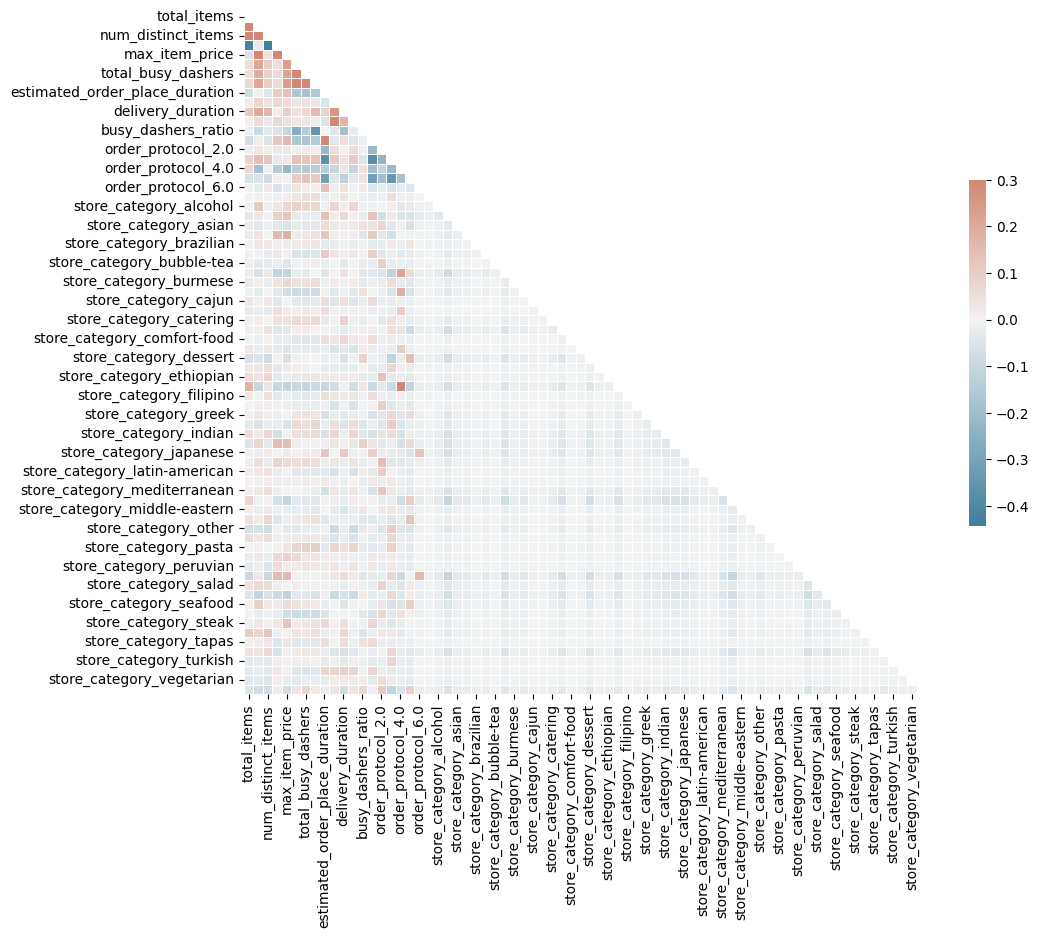

In [98]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

Defining two functions to analyze correlations in a DataFrame.

get_redundant_pairs(df): This function identifies redundant pairs of columns in the correlation matrix by iterating over the lower triangular part of the matrix. It returns a set containing these redundant pairs.

get_top_abs_correlations(df, n=5): This function calculates the absolute correlations between columns, sorts them in descending order, and returns the top n highest correlations. It drops the redundant pairs identified by the get_redundant_pairs function before sorting the correlations.







In [99]:
# Function to get redundant pairs
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Function to get top absolute correlations
def get_top_abs_correlations(df, n=5):
    """Sort correlations in descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [142]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(ride_data, 20))

Top Absolute Correlations
estimated_prep_time                           prep_duration                     1.000000
estimated_store_to_consumer_driving_duration  estimated_prep_time               0.996647
                                              prep_duration                     0.996647
total_onshift_dashers                         total_busy_dashers                0.935360
                                              total_outstanding_orders          0.933115
total_busy_dashers                            total_outstanding_orders          0.929270
estimated_order_place_duration                order_protocol_1.0                0.909117
                                              order_protocol_1.0                0.909117
total_items                                   percent_distinct_item_of_total    0.471693
estimated_order_place_duration                order_protocol_3.0                0.373168
                                              order_protocol_3.0                0.37

 several columns are dropped from the ride_data DataFrame using the drop method. These columns include "created_at", "market_id", "store_id", "store_primary_category", "nan_free_store_primary_category", and "order_protocol". After dropping these columns, new dummy variables are concatenated with the ride_data DataFrame along the columns axis using the pd.concat function. The dummy variables are "order_protocol_dummies" and "store_category_dummies".







In [100]:
# don't concat market id
ride_data = pd.concat([ride_data, order_protocol_dummies, store_category_dummies], axis=1)

# Align dtype over dataset
ride_data = ride_data.astype("float32")

# Replace inf values with nan to drop all nans
ride_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ride_data.dropna(inplace=True)

New features are created in the ride_data DataFrame. Two new columns are added: "percent_distinct_item_of_total" and "avg_price_per_item". The "percent_distinct_item_of_total" column represents the percentage of distinct items out of the total items in each order, calculated by dividing the number of distinct items by the total number of items. The "avg_price_per_item" column represents the average price per item in each order, calculated by dividing the subtotal by the total number of items. After adding these new features, the "num_distinct_items" and "subtotal" columns are dropped from the DataFrame using the drop method with the inplace=True parameter.







In [101]:
# New features
ride_data["percent_distinct_item_of_total"] = ride_data["num_distinct_items"] / ride_data["total_items"]
ride_data["avg_price_per_item"] = ride_data["subtotal"] / ride_data["total_items"]
ride_data.drop(columns=["num_distinct_items", "subtotal"], inplace=True)

 A new feature called "price_range_of_items" is created in the ride_data DataFrame. This feature represents the price range of items in each order and is calculated by subtracting the minimum item price from the maximum item price. After adding this new feature, the "max_item_price" and "min_item_price" columns are dropped from the DataFrame using the drop method with the inplace=True parameter.







In [102]:
ride_data["price_range_of_items"] = ride_data["max_item_price"] - ride_data["min_item_price"]
ride_data.drop(columns=["max_item_price", "min_item_price"], inplace=True)

<a name="Multicollinearity Check"></a>

# Multicollinearity Check

Computing the Variance Inflation Factor (VIF) for a given set of features. The function utilizes the variance_inflation_factor method from the statsmodels.stats.outliers_influence module to calculate the VIF score for each feature. The result is stored in a DataFrame called vif_data, where each row represents a feature along with its corresponding VIF score. Finally, the DataFrame is sorted by VIF values in ascending order and returned.







In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Compute Variance Inflation Factor (VIF)
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(ride_data[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

The VIF computation is applied to all columns in the ride_data DataFrame except for the target variable delivery_duration. The list of features is obtained by excluding the delivery_duration column from the DataFrame. Then, the compute_vif function is called with this list of features to compute the VIF scores for each feature. The resulting DataFrame vif_data contains the features along with their corresponding VIF scores, sorted in ascending order.







In [143]:
# Apply VIF computation to all columns
features = ride_data.drop(columns=["delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,order_protocol_4.0,9.566388e-01
1,order_protocol_5.0,9.566388e-01
2,order_protocol_6.0,2.679783e+00
3,order_protocol_5.0,2.679783e+00
4,estimated_order_place_duration,3.269648e+00
...,...,...
125,store_category_french,9.285772e+13
126,store_category_ethiopian,1.200960e+14
127,store_category_fast,1.200960e+14
128,store_category_breakfast,1.407375e+14


Dropping features with the highest VIF score iteratively until all VIF scores are under 20. The process involves setting up a loop (while loop) where the condition multicollinearity is initially set to True. Within each iteration, the feature with the highest VIF score is identified, removed from the list of features, and the VIF scores are recalculated. The loop continues until there are no VIF scores above the threshold of 20. Finally, the selected features are obtained from the updated list of features with acceptable VIF scores.







In [144]:
# Drop with highest VIF score until all VIF scores are under 20
multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
selected_features

['total_outstanding_orders',
 'total_items',
 'estimated_prep_time',
 'busy_dashers_ratio',
 'estimated_order_place_duration']

<a name="feature-selection"></a>


# Feature Selection :

Performing a train-test split on the preprocessed data after feature selection and scaling. The feature matrix X is assigned the selected features from the ride_data dataframe, while the target vector y is assigned the "delivery_duration" column. The train_test_split function from scikit-learn is then used to split the data into training and testing sets, with 80% of the data reserved for training (X_train and y_train) and 20% for testing (X_test and y_test). The random_state parameter is set to 42 for reproducibility.

In [109]:
# Train-test split after scaling
X = ride_data[selected_features]
y = ride_data["delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 Generating a bar plot illustrating the feature importances calculated by a Random Forest regressor model. The RandomForestRegressor is trained on the training data (X_train and y_train). Then, for each feature in the dataset, the importance score is calculated using the feature_importances_ attribute of the trained model. These importance scores are stored in a dictionary called feats, where each feature name is associated with its importance value.

Subsequently, a DataFrame named importances is created from this dictionary, where each row corresponds to a feature, and the column "Gini-importance" holds the importance value. The DataFrame is then sorted based on the importance values and plotted as a bar plot using Matplotlib's plot function. The resulting plot visualizes the relative importance of each feature in predicting the target variable.







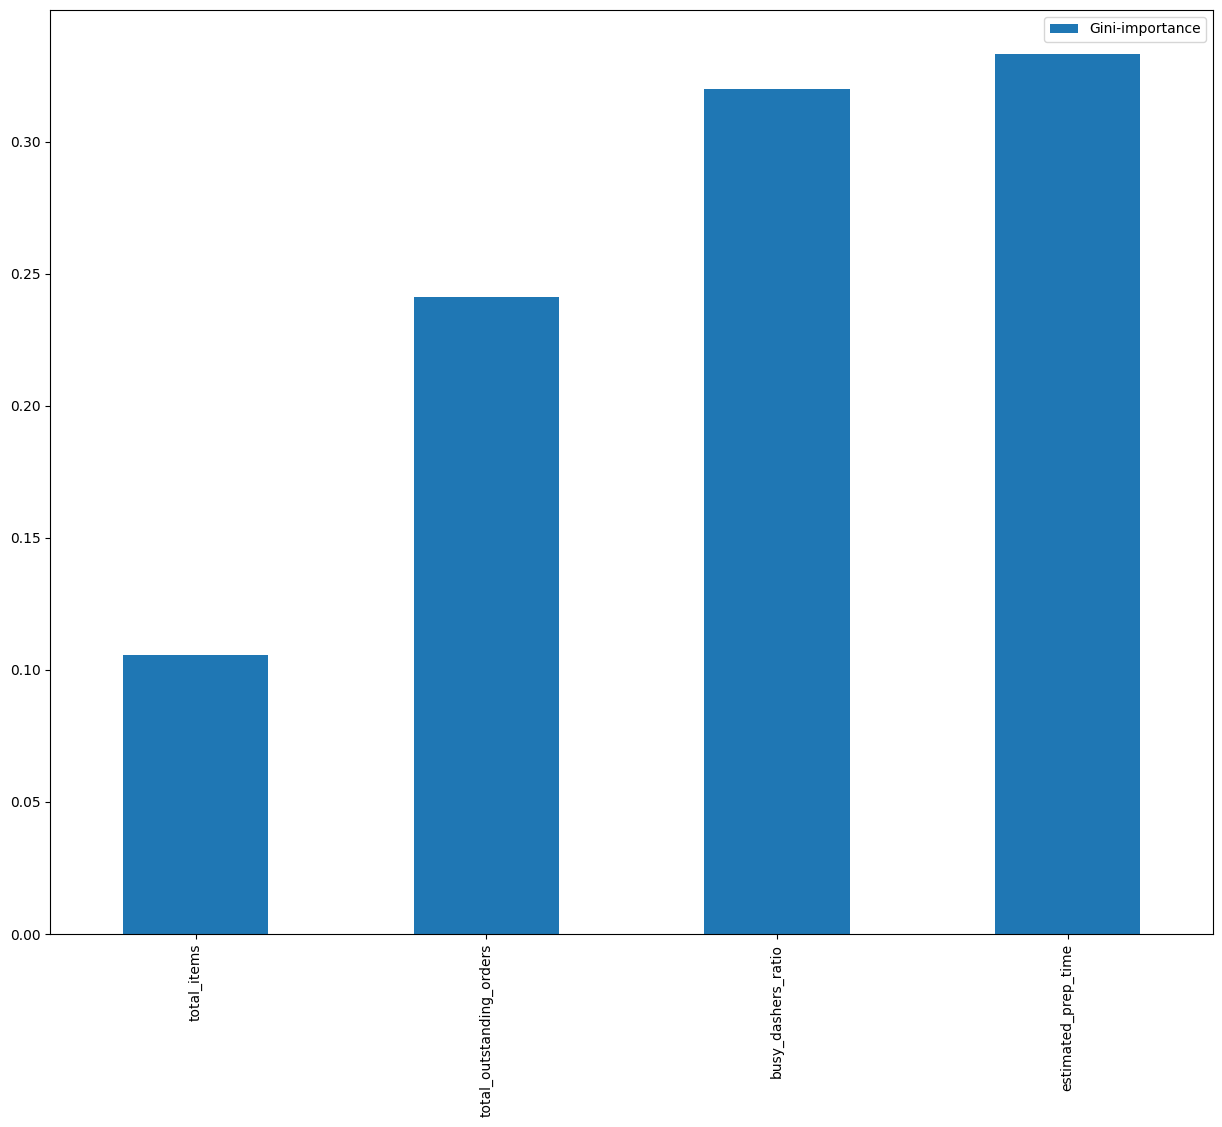

In [110]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

Generating a bar plot similar to the previous one but focuses on the top 35 most important features based on their Gini-importance scores calculated by the Random Forest regressor model. The sort_values function arranges the feature importances in ascending order, and the [-35:] slicing selects the top 35 features with the highest importances. Finally, the selected features are plotted as a bar plot using Matplotlib's plot function, with the x-axis labels rotated by 90 degrees for better readability.

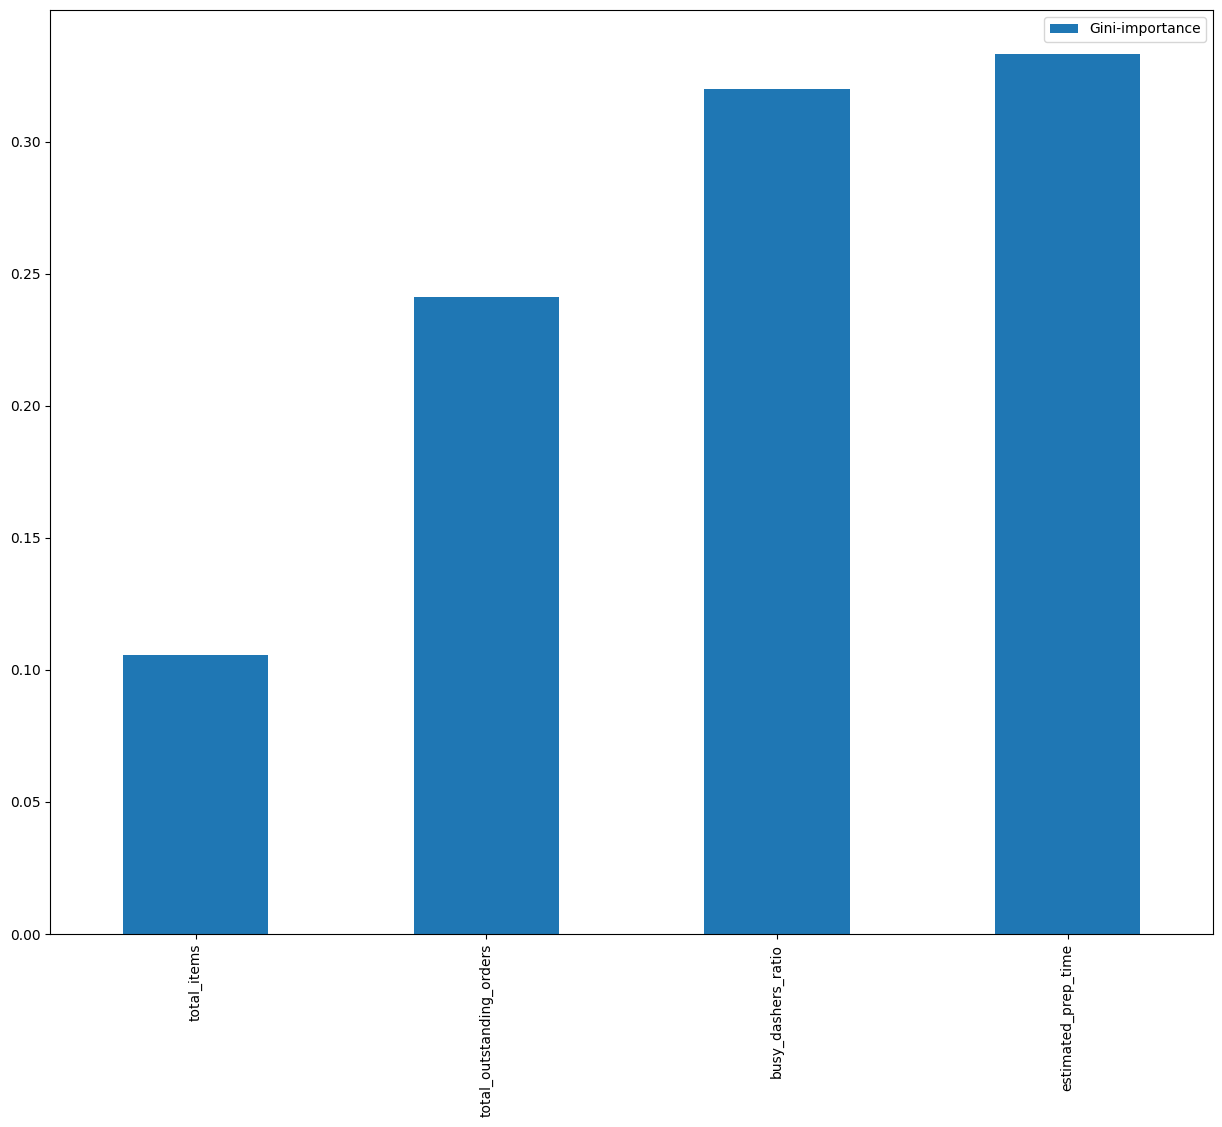

In [111]:

importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

Applying Principal Component Analysis (PCA) to visualize the cumulative explained variance as a function of the number of components. First, the features are standardized using StandardScaler to ensure that each feature has a mean of 0 and a standard deviation of 1. Then, PCA is fitted to the standardized data. The cumulative explained variance ratio is plotted against the number of components using Matplotlib. The x-axis represents the number of principal components, while the y-axis indicates the cumulative explained variance.







/tmp/ipykernel_6218/2569749091.py:10: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


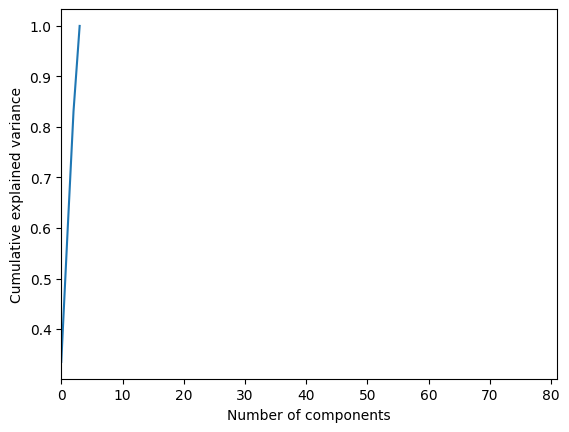

In [112]:
# apply PCA to see feature contributions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_Train=X_train.values
X_Train=np.asarray(X_Train)
# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

<a name="apply-scaler"></a>

# Apply Scaler :

Taking a scaler object along with features (X) and target variables (y) as input. It applies the scaler to both features and target variables. First, it fits the scaler to the features and transforms them using fit_transform. Then, it fits the scaler to the target variable and transforms it accordingly. Finally, it returns the scaled features (X_scaled), scaled target variable (y_scaled), as well as the fitted scalers for both features and target variables (X_scaler and y_scaler, respectively).

In [113]:
# Scale features and target variables
def scale_data(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    return X_scaled, y_scaled, X_scaler, y_scaler

 Scaling the features (X) and target variable (y) using the scale_data function with MinMaxScaler. It then splits the scaled data into training and testing sets using train_test_split, resulting in scaled training and testing features (X_train_scaled, X_test_scaled) as well as scaled training and testing target variables (y_train_scaled, y_test_scaled).

In [114]:
X_scaled, y_scaled, X_scaler, y_scaler = scale_data(MinMaxScaler(), X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

<a name="inverse-transform-for-metric-comparison"></a>

# Inverse Transform for Metric Comparison :

Calculating the Root Mean Squared Error (RMSE) between the predicted target values (y_pred_scaled) and the actual target values (y_test), after inverse transforming the predicted values using the provided scaler. The RMSE value and the inverse-transformed predicted target values are returned. Additionally, the name of the model (model_name) is printed along with the error value.







In [115]:

# Function to compute Root Mean Squared Error (RMSE) with inverse transform
def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared=False)
    print("Error =", rmse_error, "in", model_name)
    return rmse_error, y_predict

<a name="classical-machine-learning"></a>

# Classical Machine Learning :

Performing regression using a specified machine learning model (model) on training data (X_train, y_train) and evaluate its performance on test data (X_test, y_test). It returns the trained model, the predicted target values for the test data, and the errors (RMSE) on both the training and test sets. Additionally, if the verbose parameter is set to True, it prints out the training and test errors along with the model name (model_name).







In [116]:
# Create a generic function to work with multiple machine learning models
def perform_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict_train = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict_train, squared=False)
    y_predict_test = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict_test, squared=False)
    if verbose:
        print("Train error =", train_error, "in", model_name)
        print("Test error =", test_error, "in", model_name)
    return model, y_predict_test, train_error, test_error

Setting up a dictionary pred_dict to store the results of model predictions and evaluation metrics. It initializes dictionaries for regression models (regression_models), feature sets (feature_sets), and scalers (scalers). Then, it iterates over each combination of feature sets and scalers to fit regression models and evaluate their performance. For each combination, it prints a message indicating the scaler used and the included columns in the feature set. It then fits each regression model, either with or without scaling depending on the scaler chosen, calculates the error metrics (RMSE), and stores the results in the predicted_dict. Finally, it collects the results for each combination of regression model, feature set, and scaler into the pred_dict dictionary

In [117]:
pred_dict = {
"regression_model": [],
"feature_set": [],
"scaler_name": [],
"RMSE": [],
}

# Regression models
regression_models = {
    "Ridge": Ridge(),
    "DecisionTree": DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

# Feature sets
feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": selected_features[-40:],
    "selected_features_20": selected_features[-20:],
    "selected_features_10": selected_features[-10:],
}

# Scalers
scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}



# Examine the error for each combination
predicted_dict = {"regression_model": [], "feature_set": [], "scaler_name": [], "RMSE": []}
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                model, y_pred, train_error, test_error = perform_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name)
            else:
                model, y_pred, train_error, test_error = perform_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], regression_models[model_name], model_name)

            predicted_dict["regression_model"].append(model_name)
            predicted_dict["feature_set"].append(feature_set_name)
            predicted_dict["scaler_name"].append(scaler_name)
            predicted_dict["RMSE"].append(test_error)


-----scaled with Standard scaler-------- included columns are full dataset

Train error = 0.124365106 in Ridge
Test error = 0.118846186 in Ridge
Train error = 0.0932187043458754 in DecisionTree
Test error = 0.12865296180859523 in DecisionTree
Train error = 0.046142517606877265 in RandomForest
Test error = 0.1175192609959112 in RandomForest
Train error = 0.0109466165 in XGBoost
Test error = 0.13466884 in XGBoost
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 4
[LightGBM] [Info] Start training from score 0.267056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/home/qritrim/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 20.29382 in MLP
Test error = 18.634487 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Train error = 0.124365106 in Ridge
Test error = 0.118846186 in Ridge
Train error = 0.0932187043458754 in DecisionTree
Test error = 0.12865296180859523 in DecisionTree
Train error = 0.047035992341026324 in RandomForest
Test error = 0.11705655700646808 in RandomForest
Train error = 0.0109466165 in XGBoost
Test error = 0.13466884 in XGBoost
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 4
[LightGBM] [Info] Start training from score 0.267056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/qritrim/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 20.288263 in MLP
Test error = 18.717398 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Train error = 0.124365106 in Ridge
Test error = 0.118846186 in Ridge
Train error = 0.0932187043458754 in DecisionTree
Test error = 0.12865296180859523 in DecisionTree
Train error = 0.04679798781500001 in RandomForest
Test error = 0.11792078251229508 in RandomForest
Train error = 0.0109466165 in XGBoost
Test error = 0.13466884 in XGBoost
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 4
[LightGBM] [Info] Start training from score 0.267056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/qritrim/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 20.413767 in MLP
Test error = 18.738909 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Train error = 0.124365106 in Ridge
Test error = 0.118846186 in Ridge
Train error = 0.0932187043458754 in DecisionTree
Test error = 0.12865296180859523 in DecisionTree
Train error = 0.04711584672400204 in RandomForest
Test error = 0.11874587421325519 in RandomForest
Train error = 0.0109466165 in XGBoost
Test error = 0.13466884 in XGBoost
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 4
[LightGBM] [Info] Start training from score 0.267056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/qritrim/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Creating a DataFrame from the results stored in the predicted_dict dictionary, which contains information about the regression model, feature set, scaler name, and RMSE. Then, it plots the results as a bar chart using the plot function, with the regression model, feature set, and scaler name as the x-axis labels and the RMSE values as the y-axis values. The figsize parameter sets the size of the plot to (12, 8) inches.

<Axes: >

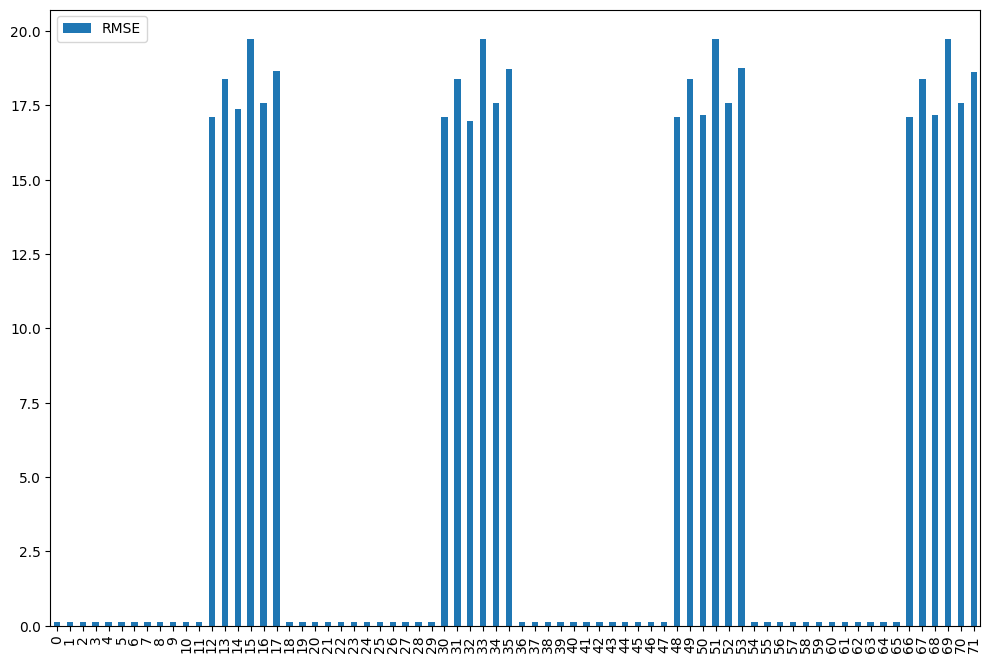

In [118]:
# Create dataframe from results
predicted_dataframe = pd.DataFrame(predicted_dict)
# Plot results
predicted_dataframe.plot(kind='bar', figsize=(12, 8))

Generating a bar plot using the predicted_dataframe DataFrame. Each bar represents a combination of regression model, feature set, and scaler name, with the height of the bar corresponding to the RMSE (Root Mean Squared Error) value. The figsize parameter specifies the dimensions of the plot as (12, 8) inches.

<Axes: >

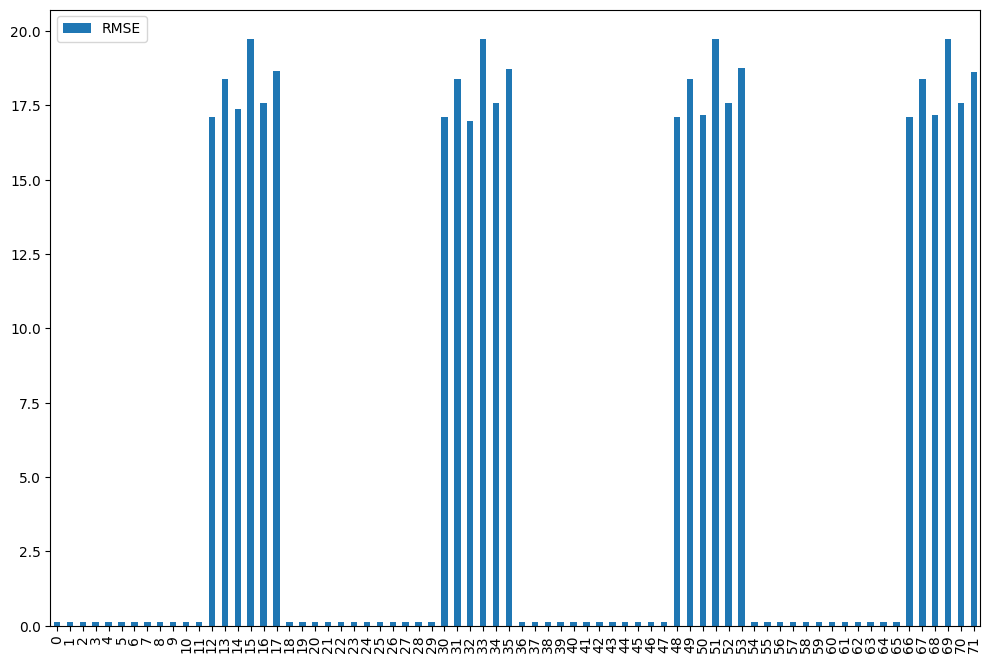

In [119]:
predicted_dataframe.plot(kind='bar', figsize=(12,8))

Changing the problem from predicting delivery duration to predicting preparation duration by subtracting the estimated store-to-consumer driving duration from the actual total delivery duration. It continues to scale the data for modeling purposes, using the standard scaler. The feature set is now limited to the top 40 features based on their Gini importance.

The loop iterates over different combinations of regression models, feature sets, and scalers, training and evaluating models accordingly. After obtaining predictions, it calculates the RMSE (Root Mean Squared Error) and appends the results to the predicted_dict dictionary.







In [121]:
ride_data

,total_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,estimated_prep_time,busy_dashers_ratio,order_protocol_1.0,...,store_category_sushi,store_category_tapas,store_category_thai,store_category_turkish,store_category_vegan,store_category_vegetarian,store_category_vietnamese,percent_distinct_item_of_total,avg_price_per_item,price_range_of_items
3500,3.0,86.0,76.0,114.0,251.0,305.0,36.333332,268.666656,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,2200.000000,1500.0
186776,7.0,149.0,118.0,209.0,251.0,436.0,52.283333,383.716675,0.564593,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,516.285706,351.0
138008,3.0,9.0,9.0,15.0,251.0,492.0,98.033333,393.966675,0.600000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,433.333344,310.0
23833,2.0,72.0,63.0,75.0,251.0,673.0,25.516666,647.483337,0.840000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,845.000000,100.0
196064,1.0,45.0,45.0,72.0,251.0,494.0,36.500000,457.500000,0.625000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,898.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67476,2.0,98.0,96.0,161.0,251.0,475.0,52.000000,423.000000,0.596273,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,865.000000,460.0
162395,3.0,7.0,7.0,7.0,251.0,341.0,57.683334,283.316681,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,566.666687,575.0
74945,4.0,125.0,73.0,143.0,251.0,505.0,32.049999,472.950012,0.510490,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,672.750000,849.0
8737,8.0,15.0,12.0,17.0,251.0,583.0,35.900002,547.099976,0.705882,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625000,549.375000,875.0


In [128]:
# Change the problem
ride_data["prep_duration"] = ride_data["delivery_duration"] - ride_data["estimated_store_to_consumer_driving_duration"]

# Scaling affects the performance, so continue to scale but it doesn't matter much which scale
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # Drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = ride_data[feature_set]
            y = ride_data["prep_duration"]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            # Scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale_data(scalers[scaler_name], X, y)

            # Apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

            _, y_predict_scaled, _, _ = perform_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], regression_models[model_name], model_name)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            predicted_dict["regression_model"].append(model_name)
            predicted_dict["feature_set"].append(feature_set_name)
            predicted_dict["scaler_name"].append(scaler_name)
            predicted_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

Train error = 0.0014372402 in Ridge
Test error = 0.0013637607 in Ridge
Error = 0.29969627 in Ridge
Train error = 0.019934716187768636 in DecisionTree
Test error = 0.025054130106158853 in DecisionTree
Error = 5.505719932144976 in DecisionTree
Train error = 0.00474373255528567 in RandomForest
Test error = 0.006520668056975963 in RandomForest
Error = 1.4329361154332139 in RandomForest
Train error = 0.0021314125 in XGBoost
Test error = 0.020137664 in XGBoost
Error = 4.425318 in XGBoost
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 4
[LightGBM] [Info] Start training from score 0.016093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

The approach of using a scaler is continued as it has been found to positively impact model performance. The scaler chosen is the standard scaler, as it is known to work well with many machine learning algorithms.

The feature set is limited to the top 40 features based on their Gini importance. The loop then iterates over different combinations of regression models, feature sets, and scalers, training and evaluating models accordingly. The best performing model chosen for this task is the LightGBM Regressor.

After obtaining predictions, the RMSE (Root Mean Squared Error) is calculated and appended to the predicted_dict dictionary for further analysis.







In [130]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scale
scalers = {
"Standard scaler": StandardScaler(),
}
feature_sets = {
"selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}
# continue
# Continue with best performing model
regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # Drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = ride_data[feature_set]
            y = ride_data["prep_duration"]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            # Scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale_data(scalers[scaler_name], X, y)

            # Apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

            _, y_predict_scaled, _, _ = perform_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], regression_models[model_name], model_name)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            predicted_dict["regression_model"].append(model_name)
            predicted_dict["feature_set"].append(feature_set_name)
            predicted_dict["scaler_name"].append(scaler_name)
            predicted_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are selected_features_40

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 4
[LightGBM] [Info] Start training from score 0.016093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

 The best performing model is chosen based on the lowest RMSE (Root Mean Squared Error). Once the best model is identified, the predictions for the preparation duration are extracted along with other relevant information such as the actual total delivery duration, estimated store to consumer driving duration, and estimated order place duration. These predictions can then be used for further analysis or decision-making processes.







In [132]:
# Choose best performing model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": ride_data["delivery_duration"][test_indices].values,
    "prep_duration_prediction": y_predict[:, 0].tolist(),
    "estimated_store_to_consumer_driving_duration": ride_data["estimated_store_to_consumer_driving_duration"][test_indices].values,
    "estimated_order_place_duration": ride_data["estimated_order_place_duration"][test_indices].values
}



The predictions and related data are converted into a pandas DataFrame from a dictionary format. This DataFrame, named values_df, allows for easier manipulation, analysis, and visualization of the prediction results and associated information.

In [134]:
# Convert it to a dataframe from dictionary
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,14.916667,-206.128915,222.0,251.0
1,56.566666,-792.689589,837.0,251.0
2,42.966667,-609.101088,654.0,251.0
3,75.266670,-274.924541,348.0,251.0
4,96.666664,-802.988319,892.0,251.0
...,...,...,...,...
167,41.583332,-367.829180,409.0,251.0
168,32.633335,-485.337210,520.0,251.0
169,99.616669,-663.040938,763.0,446.0
170,77.533333,-701.714540,781.0,251.0



The total delivery duration is computed by summing up the preparation duration prediction with the estimated store-to-consumer driving duration and the estimated order place duration. This calculation is performed to obtain a comprehensive view of the total time taken for the entire delivery process, including all relevant ac

In [136]:

# Sum predictions up with non-preparation activities such as order placing and driving
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]


The mean squared error between the actual total delivery duration and the summed total delivery duration is computed. This provides a measure of the accuracy of the predictions considering all aspects of the delivery process.

In [137]:

# Check new error rate
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"])


96461.39435766666

 Another regression model is utilized to predict the actual total delivery duration. The features used for this regression include the predicted preparation duration, estimated store-to-consumer driving duration, and estimated order place duration. These features are used to train the regression model, and then the model's performance is evaluated using a train-test split of the data.







In [138]:
# Use another regression to obtain the actual total delivery duration
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Iterating over a dictionary of regression models including Linear Regression, Ridge Regression, Decision Tree Regression, Random Forest Regression, XGBoost, LightGBM, and MLPRegressor. For each model, it trains the model on the training data (X_train, y_train) and then predicts the target variable for the test data (X_test). Finally, it calculates the root mean squared error (RMSE) between the predicted values and the actual values for each model and prints out the RMSE values. This allows for the comparison of the performance of different regression models on the given

In [139]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

regression_models = {
"LinearReg" : linear_model.LinearRegression(),
"Ridge" : linear_model.Ridge(),
"DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
"RandomForest" : RandomForestRegressor(),
"XGBoost": XGBRegressor(),
"LGBM": LGBMRegressor(),
"MLP": MLPRegressor()
}

for model_name in regression_models.keys():
    _, y_predict, _, _ = perform_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print("RMSE of:", model_name, mean_squared_error(y_test, y_predict, squared=False))


RMSE of: LinearReg 8.744092392550098
RMSE of: Ridge 8.743989198653974
RMSE of: DecisionTree 16.310754889228747
RMSE of: RandomForest 14.479379398132485
RMSE of: XGBoost 12.000644
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 3
[LightGBM] [Info] Start training from score 50.078589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

<a name="deep-learning"></a>

# Deep Learning :

 Defining a function create_model to build a neural network using Keras. The function takes the size of the feature set as input and constructs a sequential model. The neural network architecture consists of an input layer with a specified number of neurons (determined by the feature set size), a hidden layer with 16 neurons, and an output layer with a single neuron. The activation function for the hidden layer is ReLU, and for the output layer, it's linear since it's a regression problem. The model is compiled using stochastic gradient descent (SGD) as the optimizer and mean squared error (MSE) as the loss function. Additionally, it calculates the root mean squared error (RMSE) as a metric during training.







In [140]:
# Neural Network
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)
# Neural network
def create_model(feature_set_size):
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


2024-02-11 10:47:50.914168: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 10:47:50.942925: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 10:47:51.080182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 10:47:51.081052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 10:47:52.113780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

 prints a message indicating the scaling method and the included columns for the current iteration of the model evaluation loop. After printing this message, it sets up the data for training and testing an Artificial Neural Network (ANN) regression model.

The features used for training the ANN model are the predicted preparation duration, estimated store-to-consumer driving duration, and estimated order place duration. The target variable is the actual total delivery duration. The data is split into training and testing sets, scaled using the specified scaler (Standard scaler), and then split into scaled training and testing sets.

Next, it prints the size of the feature set used in the model. The create_model function is called to create the ANN model with the appropriate input size based on the number of features in the training set. The model is then trained using the scaled training data for 100 epochs with a batch size of 64.

After training, the model predicts the delivery durations for the test set, and the root mean squared error (RMSE) is calculated using the rmse_with_inv_transform function to evaluate the model's performance. Finally, the RMSE and other relevant information are appended to the predicted_dict dictionary for further analysis and comparison with other models.

In [141]:


print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")

model_name = "ANN"
scaler_name = "Standard scaler"

X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale_data(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("feature_set_size:", X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)

predicted_dict["regression_model"].append(model_name)
predicted_dict["feature_set"].append(feature_set_name)
predicted_dict["scaler_name"].append(scaler_name)
predicted_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7918 - root_mean_squared_error: 1.3386
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 1.5551 - root_mean_squared_error: 1.2470
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3898 - root_mean_squared_error: 1.1789
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2986 - root_mean_squared_error: 1.1396
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 1.1496 - root_mean_squared_error: 1.0722
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 1.1097 - root_mean_squared_error: 1.0534
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0793 - root_mean_squared_error: 1.0389
Epoch 8/100
3/3 [==============================] - 0s 2ms/step - loss: 1.0679 - root_mean_squared_error: 1.0334
